In [1]:
import io
from pathlib import Path 
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.pylabtools import figsize

figsize(8, 8)

In [2]:
datapath = Path("/media/hemu/Data/Markets/FX/truefx/GBPJPY-zip")



In [3]:
def read_and_parse_truefx(filepath):
    df = pd.read_csv(filepath, header=None, parse_dates=True)
    df.columns = ('asset', 'timestamp', 'bid', 'ask')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.drop('asset', axis=1).set_index('timestamp')

In [4]:
files = list(datapath.iterdir())
print(len(files))

df = read_and_parse_truefx(files[0])

125


In [5]:
df[['ask', 'bid']].mean()

ask    146.518591
bid    146.494028
dtype: float64

/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


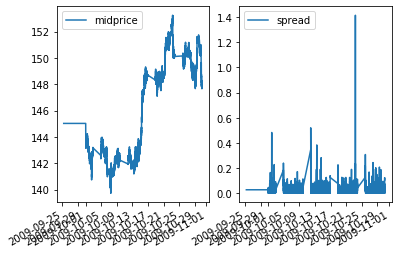

In [6]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, sharex=True)
ax[0].plot(df[['ask', 'bid']].mean(axis=1), label='midprice')
ax[1].plot(df['ask'] - df['bid'], label='spread')
ax[0].legend()
ax[1].legend()
fig.autofmt_xdate()

## GH Filter

In [7]:
import numba 

@numba.njit
def gh_filter(data, x0, dx, g, h, dt):
    est = x0
    out = np.empty(len(data))
    for i, z in enumerate(data):
        x_pred = est + dx*dt
        dx = dx

        res = z-x_pred
        dx = dx + h * res/dt
        est = x_pred + g*res
        out[i] = est
    return out

In [8]:
midprice = df[['bid', 'ask']].mean(axis=1)
est = gh_filter(midprice.to_numpy(), midprice[0], 0., .5, 0.4, 1)

/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


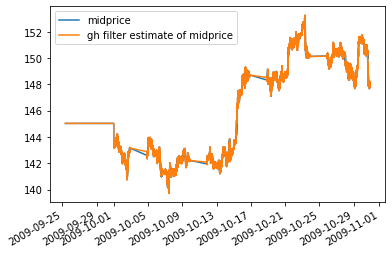

In [9]:
fig, ax = plt.subplots(1, sharex=True, sharey=True)
ax.plot(df[['ask', 'bid']].mean(axis=1), label='midprice')
ax.plot(df.index, est, label='gh filter estimate of midprice')
ax.legend()
fig.autofmt_xdate()

## Kalman

## Segmenting via Trend Persistance CrossOvers

In [10]:
# from pandas.api.types import CategoricalDtype
# cat_type = CategoricalDtype(categories=[0, 1])
# part=part.astype(cat_type)

def move_mean_part(prices, windowA, windowB):
    diff = (midprice.rolling(windowA).mean() - midprice.rolling(windowB).mean()).dropna()
    part = pd.Series(np.zeros_like(diff), dtype=np.int)
    part.iloc[(diff<0.).to_numpy()] = 0
    part.iloc[(diff>0.).to_numpy()] = 1
    return part


In [11]:

def get_cross_lengths(part):
    crossover = part != part.shift()
    n_crosses = crossover.cumsum()
    cross_lengths = crossover.groupby(n_crosses).count()
    return cross_lengths


In [12]:
part = move_mean_part(midprice, 10, 50)
cross_lengths = get_cross_lengths(part) 
cross_lengths

1         37
2         16
3         49
4         24
5        101
        ... 
64909     37
64910     77
64911      1
64912     10
64913      4
Length: 64913, dtype: int64

n_crosses 64913
mean_cross_length 37.54280344461048
max_cross_length 442
min_cross_length 1


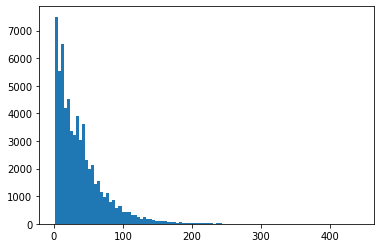

In [13]:
print( 'n_crosses',  len(cross_lengths))
print('mean_cross_length', cross_lengths.mean())
print('max_cross_length', cross_lengths.max())
print('min_cross_length', cross_lengths.min())
_ = plt.hist(cross_lengths, bins=100)

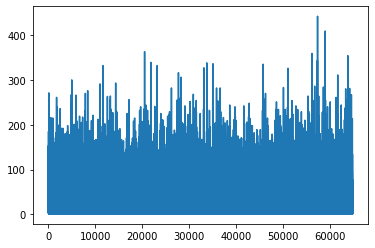

In [14]:
plt.plot(cross_lengths)

In [15]:
def empirical_cdf(dist, z):
    return len(dist[dist > z]) / len(dist)

def empirical_cdf_frac(dist, z1, z2):
    p1 = empirical_cdf(dist, z1)
    p2 = empirical_cdf(dist, z2)
    p2_p1_frac = empirical_cdf(dist[dist > z1], z2)
    return p1, p2,  p2_p1_frac

In [16]:
z1 = 50
z2 = 100
p1, p2, p2_p1_frac = empirical_cdf_frac(cross_lengths, z1, z2)

p2_est = empirical_cdf(cross_lengths, z1 ) * z1/z2

print(f'linear scaling p({z2}) est p({z1})*z1/z2:  ', p2_est)
print('-'*40)

print(f'p({z1}):     ', p1)
print(f'p({z2}):     ', p2)
print(f'p({z1})<p({z2}): ', p2_p1_frac)

linear scaling p(100) est p(50)*z1/z2:   0.12878005946420593
----------------------------------------
p(50):      0.25756011892841185
p(100):      0.05901745413091369
p(50)<p(100):  0.2291404988336623


/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


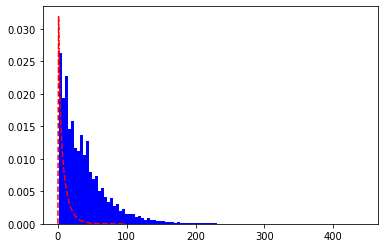

In [111]:
%matplotlib inline
# %matplotlib notebook

from scipy import stats

empirical = cross_lengths
# dist = stats.betabinom
dist = stats.beta
kernel = lambda x: x

params = dist.fit(kernel(empirical))
x = np.linspace(0, empirical.max(), 100)
pdf = dist.pdf(x, *params)
plt.hist(kernel(empirical), 100, color='b', normed=True)
plt.plot(pdf, '--r')


/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[]

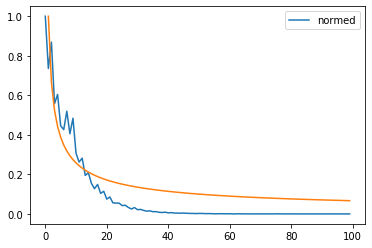

In [115]:
freq, bins  = np.histogram(cross_lengths, bins=100)
normed = freq / freq[0]
zipf_ref = 1/ np.arange(len(normed))**(1/1.7)
plt.plot(normed, label='normed')
plt.plot(zipf_ref)
plt.legend()
plt.plot()

In [109]:
freq, bins  = np.histogram(cross_lengths, bins=100)
freq = np.concatenate([freq, [0]], axis=0)

params = np.polyfit(bins, freq, 5)
print(params)
poly_model = np.polynomial.polynomial.Polynomial(params)
poly_model.fit(bins, freq, 5)
# plt.plot(poly_model(freq), label='poly fit')
# plt.hist(cross_lengths, bins=100, label='empirical')
# plt.legend()

[-6.33728011e-09  8.70768063e-06 -4.60468730e-03  1.17023851e+00
 -1.43500088e+02  6.88896034e+03]


Polynomial([   59.18591374,  -130.17311426,  -727.1781301 ,    11.85210559,
        3993.01341196, -3303.28368606], domain=[  1., 442.], window=[-1.,  1.])

In [ ]:
x = np.linspace(0, 1, 100)
y = 10* x + np.random.randn(100)
plt.plot(y)
p = np.polyfit(x, y, 2)

plt.plot(np.polynomial.polynomial.Polynomial(p)(x))


In [ ]:
unique = np.log(cross_lengths).unique()
unique.sort()
unique